- Minecraft Version 1.21.5
- Seed: "vcpi"
- Gamerules: "doDaylightCycle=false" "doWeatherCycle=false" "doMobSpawning=false"
- Commands. /time set day
- render distance: 12

In [18]:
import os
import time

from tqdm import tqdm
from pathlib import Path
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms

from src.dataset import PairedImageDataset

cuda = torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")
print(f"Using device: {device}")

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Using device: cuda


In [19]:
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

full_dataset = PairedImageDataset("generator_bot/screenshots", transforms=transform)

dataset_size = len(full_dataset)
test_size = int(0.2 * dataset_size)
train_size = dataset_size - test_size

print(f"Total dataset size: {dataset_size}")
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 4

train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4)

print(f"Train batches: {len(train_dl)}")
print(f"Test batches: {len(test_dl)}")

Total dataset size: 1303
Train size: 1043
Test size: 260
Train batches: 261
Test batches: 65


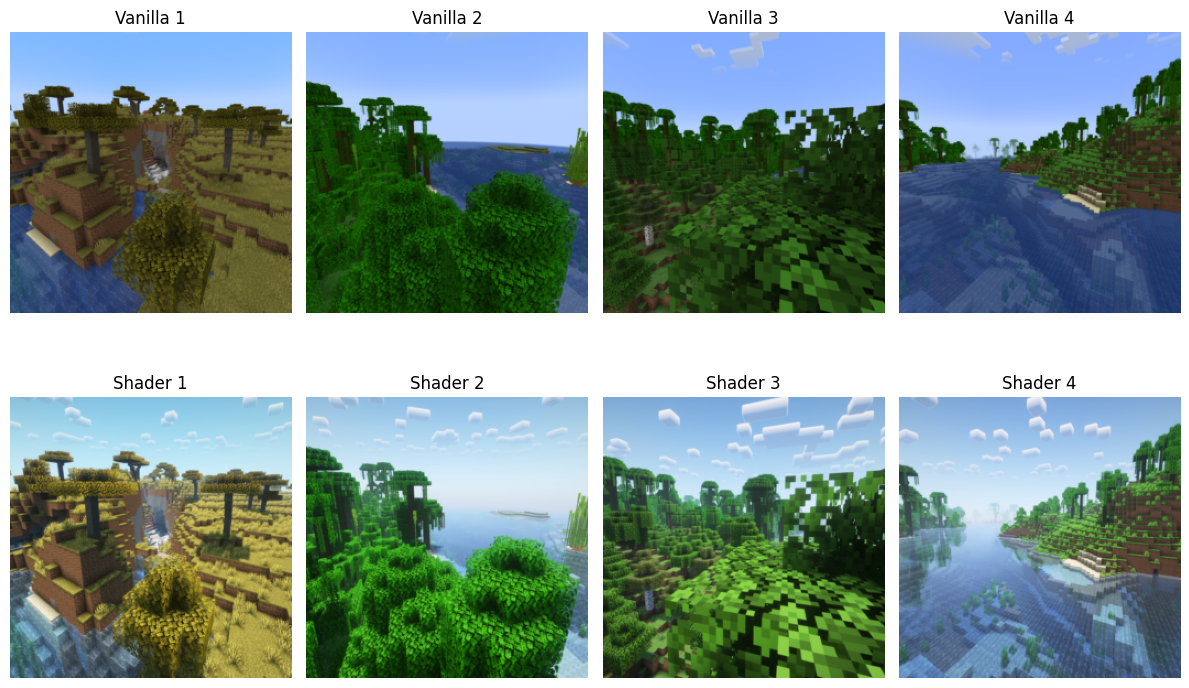

In [20]:
# Show some pairs of images using pyplot
plt.figure(figsize=(12, 8))

# Get a batch of data
batch = next(iter(train_dl))

vanilla_images = batch["vanilla"]
shader_images = batch["shader"]


def denormalize(tensor):
    return (tensor + 1.0) / 2.0


# Display pairs of images
for i in range(min(4, vanilla_images.size(0))):
    # Vanilla image
    plt.subplot(2, 4, i + 1)
    vanilla_img = denormalize(vanilla_images[i]).permute(1, 2, 0)
    plt.imshow(vanilla_img.cpu().numpy())
    plt.title(f"Vanilla {i + 1}")
    plt.axis("off")

    # Shader image
    plt.subplot(2, 4, i + 5)
    shader_img = denormalize(shader_images[i]).permute(1, 2, 0)
    plt.imshow(shader_img.cpu().numpy())
    plt.title(f"Shader {i + 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [21]:
from src.models import GeneratorUNet, PatchDiscriminator, weights_init_normal

G = GeneratorUNet().to(device)
D = PatchDiscriminator().to(device)

G.apply(weights_init_normal)
D.apply(weights_init_normal)

g_opt = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

gan_criterion = nn.BCEWithLogitsLoss()
l1_criterion = nn.L1Loss()

In [22]:
def train_epoch(dataloader, G, D, g_opt, d_opt, gan_crit, l1_crit, lambda_l1=100):
    G.train()
    D.train()

    total_discriminator_loss = 0
    total_generator_loss = 0
    total_gan_loss = 0
    total_l1_loss = 0
    total_real_loss = 0
    total_fake_loss = 0

    num_batches = 0

    loop = tqdm(dataloader, leave=True, unit_scale=BATCH_SIZE, unit="pairs")

    for idx, batch in enumerate(loop):
        x = batch["vanilla"].to(device, non_blocking=True)
        y = batch["shader"].to(device, non_blocking=True)

        valid = torch.ones((x.size(0), 1, 16, 16), device=device)
        fake = torch.zeros_like(valid)

        # ---- Discriminator ----
        d_opt.zero_grad()
        # Real
        real_pred = D(x, y)
        d_real_loss = gan_crit(real_pred, valid)
        # Fake
        y_fake = G(x)
        fake_pred = D(x, y_fake.detach())
        d_fake_loss = gan_crit(fake_pred, fake)
        d_loss = (d_real_loss + d_fake_loss) * 0.5
        d_loss.backward()
        d_opt.step()

        # ---- Generator ----
        g_opt.zero_grad()
        # GAN loss
        fake_pred = D(x, y_fake)
        g_gan = gan_crit(fake_pred, valid)
        # Reconstruction loss
        g_l1 = l1_crit(y_fake, y) * lambda_l1
        g_loss = g_gan + g_l1
        g_loss.backward()
        g_opt.step()

        total_discriminator_loss += d_loss.item()
        total_generator_loss += g_loss.item()
        total_gan_loss += g_gan.item()
        total_l1_loss += g_l1.item()
        total_real_loss += d_real_loss.item()
        total_fake_loss += d_fake_loss.item()
        num_batches += 1

        loop.set_postfix(
            d_loss=total_discriminator_loss / (idx + 1),
            d_real_loss=total_real_loss / (idx + 1),
            d_fake_loss=total_fake_loss / (idx + 1),
            g_loss=total_generator_loss / (idx + 1),
            g_gan=total_gan_loss / (idx + 1),
            g_l1=total_l1_loss / (idx + 1),
        )

    return {
        "discriminator_loss": total_discriminator_loss / num_batches,
        "generator_loss": total_generator_loss / num_batches,
        "gan_loss": total_gan_loss / num_batches,
        "l1_loss": total_l1_loss / num_batches,
        "real_loss": total_real_loss / num_batches,
        "fake_loss": total_fake_loss / num_batches,
    }

In [23]:
def evaluate_model(dataloader, G, D, gan_crit, l1_crit, lambda_l1=100):
    """Evaluate the model on test data"""
    G.eval()
    D.eval()
    
    total_generator_loss = 0
    total_discriminator_loss = 0
    total_gan_loss = 0
    total_l1_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            x = batch["vanilla"].to(device, non_blocking=True)
            y = batch["shader"].to(device, non_blocking=True)
            
            valid = torch.ones((x.size(0), 1, 16, 16), device=device)
            fake = torch.zeros_like(valid)
            
            # Generate fake images
            y_fake = G(x)
            
            # Discriminator loss
            real_pred = D(x, y)
            fake_pred = D(x, y_fake)
            d_real_loss = gan_crit(real_pred, valid)
            d_fake_loss = gan_crit(fake_pred, fake)
            d_loss = (d_real_loss + d_fake_loss) * 0.5
            
            # Generator loss
            fake_pred = D(x, y_fake)
            g_gan = gan_crit(fake_pred, valid)
            g_l1 = l1_crit(y_fake, y) * lambda_l1
            g_loss = g_gan + g_l1
            
            total_generator_loss += g_loss.item()
            total_discriminator_loss += d_loss.item()
            total_gan_loss += g_gan.item()
            total_l1_loss += g_l1.item()
            num_batches += 1
    
    return {
        "test_generator_loss": total_generator_loss / num_batches,
        "test_discriminator_loss": total_discriminator_loss / num_batches,
        "test_gan_loss": total_gan_loss / num_batches,
        "test_l1_loss": total_l1_loss / num_batches,
    }


In [24]:
prev_time = time.time()

EPOCHS = 5

# Store training and test metrics
train_metrics = []
test_metrics = []

for epoch in range(0, EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 50)
    
    # Train
    train_results = train_epoch(train_dl, G, D, g_opt, d_opt, gan_criterion, l1_criterion)
    train_metrics.append(train_results)
    
    # Evaluate on test set
    test_results = evaluate_model(test_dl, G, D, gan_criterion, l1_criterion)
    test_metrics.append(test_results)
    
    # Print results
    print(f"Train - G Loss: {train_results['generator_loss']:.4f}, D Loss: {train_results['discriminator_loss']:.4f}")
    print(f"Test  - G Loss: {test_results['test_generator_loss']:.4f}, D Loss: {test_results['test_discriminator_loss']:.4f}")
    
    current_time = time.time()
    elapsed = current_time - prev_time
    print(f"Time elapsed: {elapsed:.2f}s")
    prev_time = current_time


Epoch 1/5
--------------------------------------------------


100%|██████████| 1044/1044 [00:33<00:00, 30.94pairs/s, d_fake_loss=0.605, d_loss=0.61, d_real_loss=0.614, g_gan=1.13, g_l1=15.7, g_loss=16.8] 


Train - G Loss: 16.8267, D Loss: 0.6097
Test  - G Loss: 13.4835, D Loss: 0.4548
Time elapsed: 40.47s

Epoch 2/5
--------------------------------------------------


100%|██████████| 1044/1044 [00:33<00:00, 30.91pairs/s, d_fake_loss=0.468, d_loss=0.474, d_real_loss=0.48, g_gan=1.54, g_l1=11.4, g_loss=13]  


Train - G Loss: 12.9832, D Loss: 0.4743
Test  - G Loss: 11.7951, D Loss: 0.4545
Time elapsed: 40.52s

Epoch 3/5
--------------------------------------------------


100%|██████████| 1044/1044 [00:33<00:00, 31.19pairs/s, d_fake_loss=0.478, d_loss=0.487, d_real_loss=0.496, g_gan=1.5, g_l1=10.9, g_loss=12.4]


Train - G Loss: 12.3525, D Loss: 0.4871
Test  - G Loss: 11.6419, D Loss: 0.4389
Time elapsed: 40.05s

Epoch 4/5
--------------------------------------------------


100%|██████████| 1044/1044 [00:33<00:00, 31.26pairs/s, d_fake_loss=0.467, d_loss=0.48, d_real_loss=0.494, g_gan=1.55, g_l1=10.5, g_loss=12.1] 


Train - G Loss: 12.0739, D Loss: 0.4801
Test  - G Loss: 10.3707, D Loss: 0.5571
Time elapsed: 40.09s

Epoch 5/5
--------------------------------------------------


100%|██████████| 1044/1044 [00:32<00:00, 32.20pairs/s, d_fake_loss=0.484, d_loss=0.496, d_real_loss=0.507, g_gan=1.55, g_l1=10.2, g_loss=11.7]
                                                           

Train - G Loss: 11.7003, D Loss: 0.4957
Test  - G Loss: 12.4663, D Loss: 0.4377
Time elapsed: 38.93s


Results on Test Set:


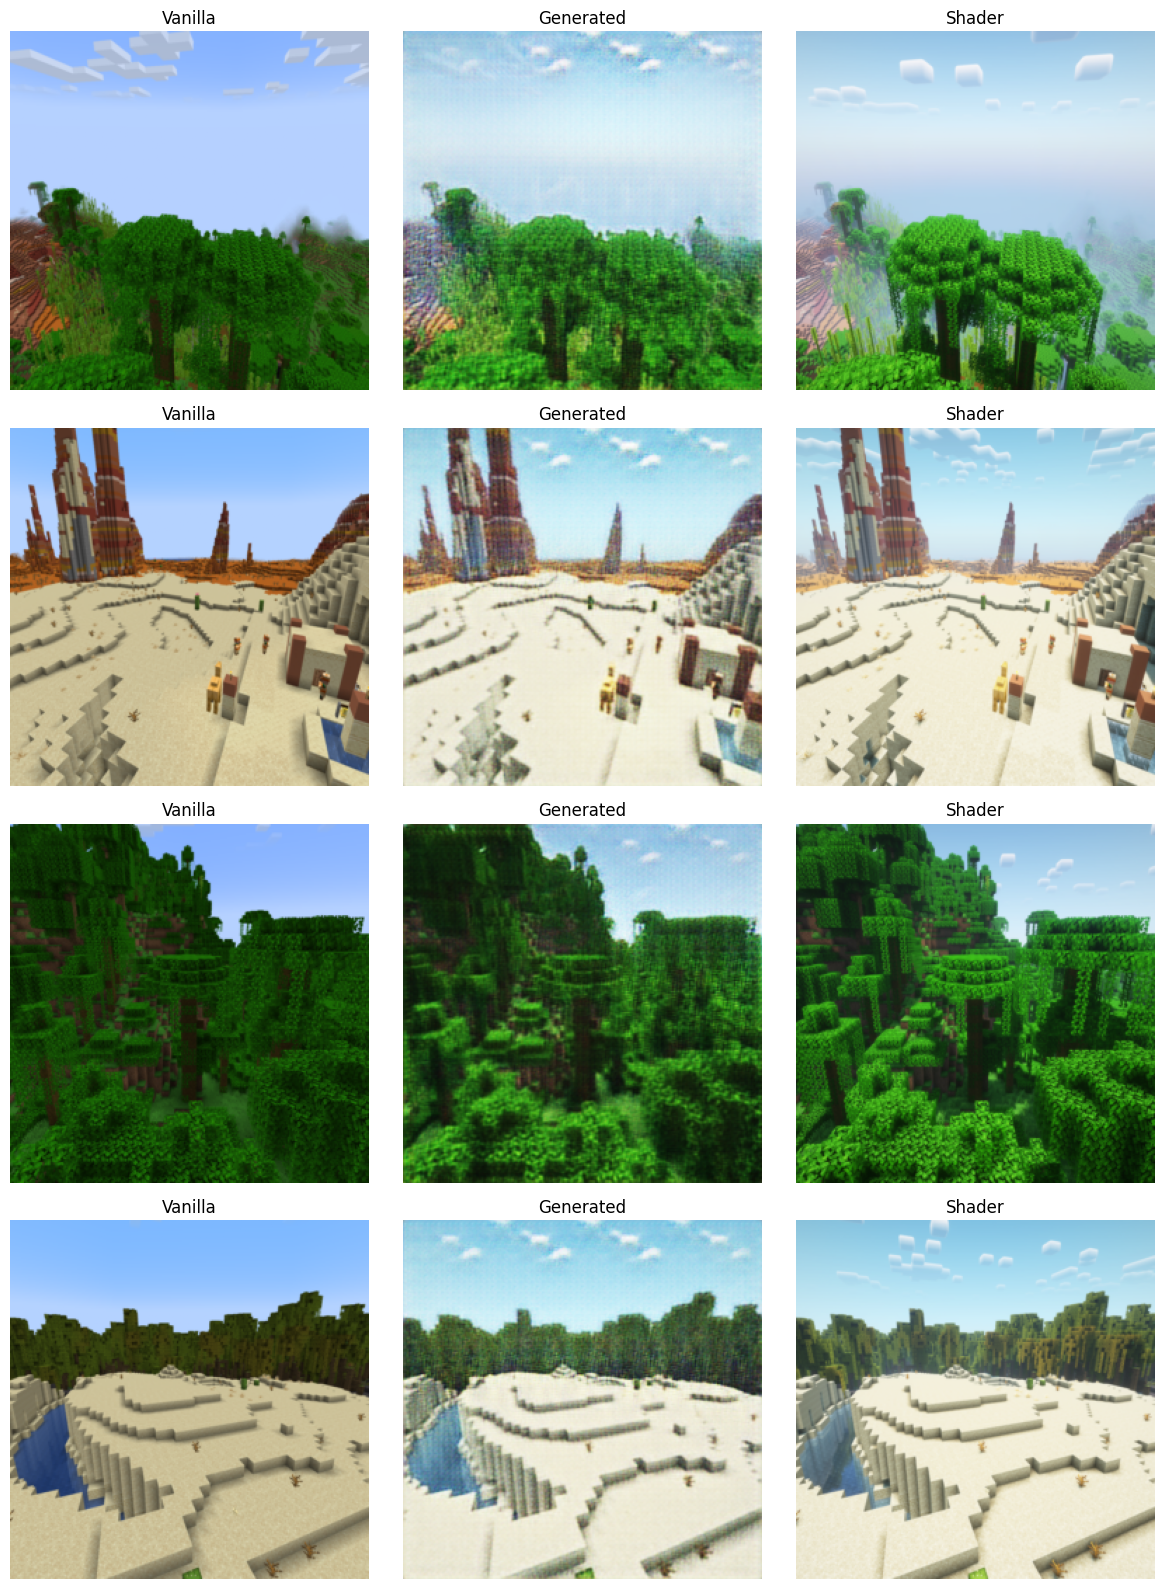

In [25]:
def show_results(x, y, y_hat, n=4):
    x = (x + 1) / 2
    y = (y + 1) / 2
    y_hat = (y_hat + 1) / 2
    fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))
    for i in range(n):
        axes[i, 0].imshow(x[i].permute(1, 2, 0).cpu())
        axes[i, 0].set_title("Vanilla")
        axes[i, 1].imshow(y_hat[i].permute(1, 2, 0).cpu())
        axes[i, 1].set_title("Generated")
        axes[i, 2].imshow(y[i].permute(1, 2, 0).cpu())
        axes[i, 2].set_title("Shader")
        for ax in axes[i]:
            ax.axis("off")
    plt.tight_layout()
    plt.show()


# Show results on test set
print("Results on Test Set:")
batch = next(iter(test_dl))
x, y = batch["vanilla"].to(device), batch["shader"].to(device)
with torch.no_grad():
    G.eval()
    y_hat = G(x)
show_results(x, y, y_hat)

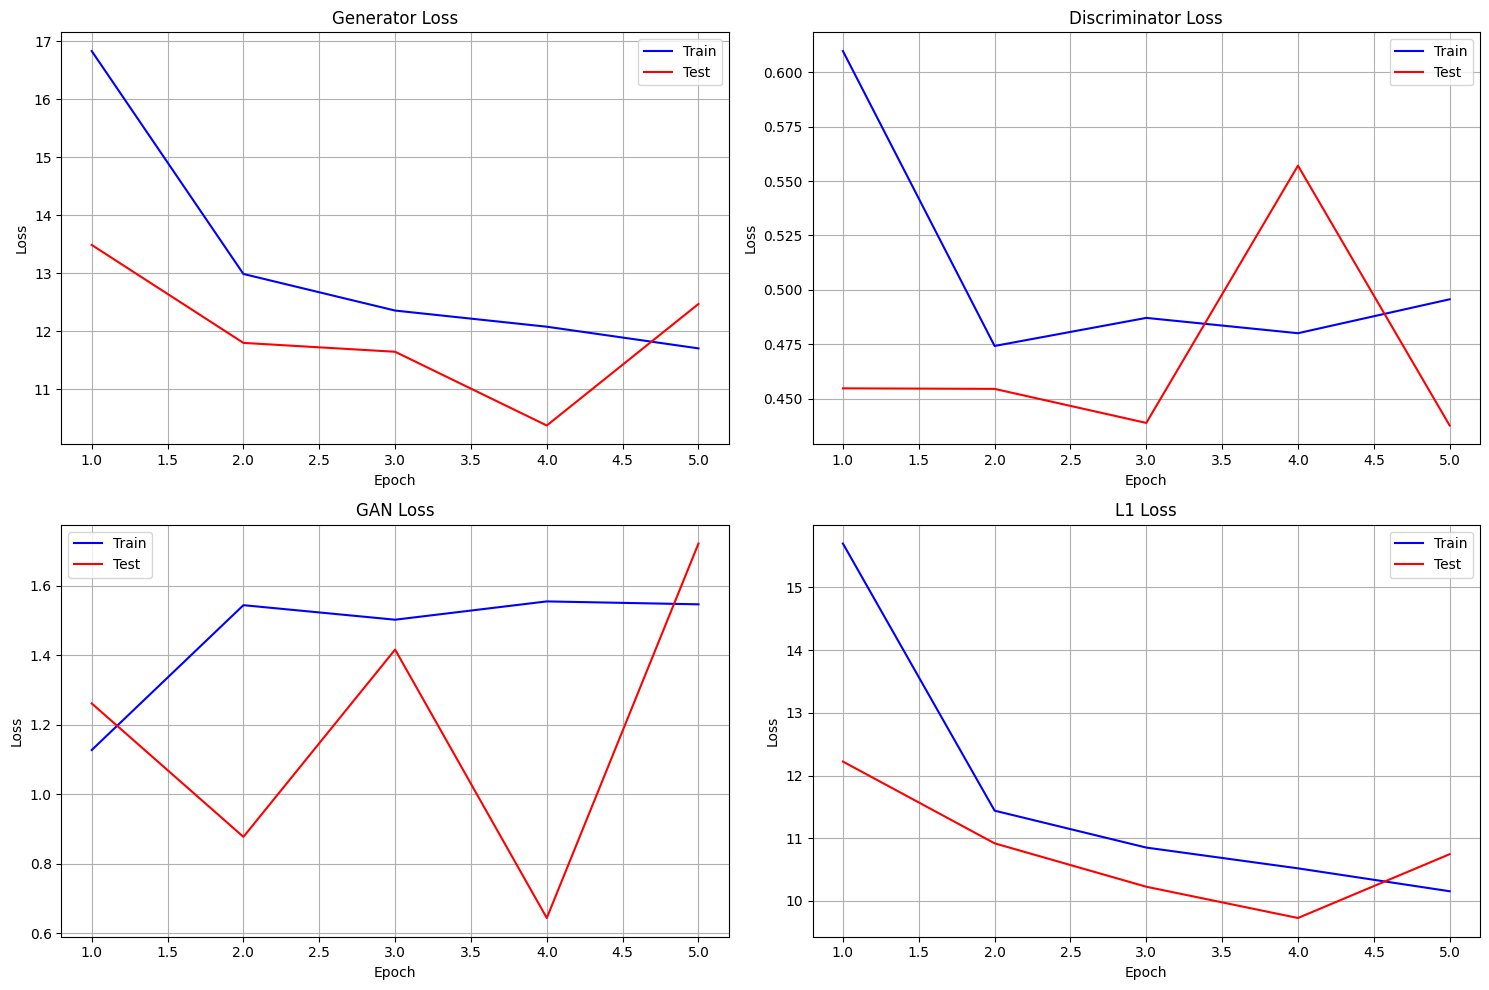


Final Metrics:
Train Generator Loss: 11.7003
Test Generator Loss: 12.4663
Train Discriminator Loss: 0.4957
Test Discriminator Loss: 0.4377


In [26]:
# Plot training and test metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(train_metrics) + 1)

# Generator Loss
axes[0, 0].plot(epochs, [m['generator_loss'] for m in train_metrics], 'b-', label='Train')
axes[0, 0].plot(epochs, [m['test_generator_loss'] for m in test_metrics], 'r-', label='Test')
axes[0, 0].set_title('Generator Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Discriminator Loss
axes[0, 1].plot(epochs, [m['discriminator_loss'] for m in train_metrics], 'b-', label='Train')
axes[0, 1].plot(epochs, [m['test_discriminator_loss'] for m in test_metrics], 'r-', label='Test')
axes[0, 1].set_title('Discriminator Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# GAN Loss
axes[1, 0].plot(epochs, [m['gan_loss'] for m in train_metrics], 'b-', label='Train')
axes[1, 0].plot(epochs, [m['test_gan_loss'] for m in test_metrics], 'r-', label='Test')
axes[1, 0].set_title('GAN Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# L1 Loss
axes[1, 1].plot(epochs, [m['l1_loss'] for m in train_metrics], 'b-', label='Train')
axes[1, 1].plot(epochs, [m['test_l1_loss'] for m in test_metrics], 'r-', label='Test')
axes[1, 1].set_title('L1 Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Metrics:")
print(f"Train Generator Loss: {train_metrics[-1]['generator_loss']:.4f}")
print(f"Test Generator Loss: {test_metrics[-1]['test_generator_loss']:.4f}")
print(f"Train Discriminator Loss: {train_metrics[-1]['discriminator_loss']:.4f}")
print(f"Test Discriminator Loss: {test_metrics[-1]['test_discriminator_loss']:.4f}")
